In [3]:
import matplotlib.pyplot as plt                 # For normal plotting

# from mpl_toolkits.mplot3d import Axes3D         # For 3D plotting
# from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

import numpy as np                              # For maths

from scipy import ndimage                       # For image rotations
# from scipy import constants                     # For scientific constants
import scipy.interpolate                        # For importing data

import copy                                     # For manipulating data

import pandas                                   # For importing data

import imageio                                  # For creating gifs

import hyperspy.api as hs
import tifffile

# import tomopy

import astra

# Plots appear embedded/windowed for inline/qt
%matplotlib inline

Generate scalar triangular prism

In [2]:
def generate_tri_pris(n = 100, size_n = 1,pi=1):
    """ 
    Generate triangular prism data (with missing slice)
    
    Input:
    n = number of nodes in each dimension (nxnxn grid)
    size_n = length in nm of each node
    
    Output:
    X,Y,Z,MX,MY,MZ = Gridded coordinates, gridded magnetisation
    """
    
    # Define gradient/intercept of bounding lines
    m1, c1 = 5, 100
    m2, c2 = 0, -25
    m3, c3 = -0.6, 0
    
    # Generate x,y,z value
    xs = np.linspace(-n/2,n/2,int(n/size_n))
    ys = np.linspace(-n/2,n/2,int(n/size_n))
    zs = np.linspace(-n/2,n/2,int(n/size_n))
    
    X,Y,Z = np.meshgrid(xs,ys,zs,indexing='ij')

    # Assign density
    data = []
    for x in xs:
        for y in ys:
            for z in zs:
                if y < (m1*x+c1) and y > (m2*x + c2) and y < (m3*x + c3) and ((z >-20 and z<-10) or (z>0 and z<40)):
                    p = pi
                    data.append([x,y,z,p])
                else:
                    p = 0
                    data.append([x,y,z,p])

    # Extract density
    P = np.take(data,3,axis=1)

    P = P.reshape(len(xs),len(ys),len(zs))
    
    return X,Y,Z,P

In [3]:
def plot_2d(X,Y,Z,P,s=5,size=0.1, width = 0.005, title='',ax=None,fig=None):
    """
    Plot magnetisation data in 2D
    
    Input:
    x,y = 'Projected' 2D coordinates (nxn)
    u,v = 'Projected' 2D magnetisation (nxn)
    s = Quiver plot skip density
    size = Arrow length scaling
    width = Arrow thickness 
    
    Output:
    2D Plot of magnetisation:
    - Arrows show direction of M
    - Background color shows magnitude of M
    """
    # Project along z by averaging
    x_proj = np.mean(X,axis=2)
    y_proj = np.mean(Y,axis=2)
    z_proj = np.mean(Z,axis=2)
    p_proj = np.mean(P,axis=2)
    
    if ax == None:
        # Create figure
        fig,ax = plt.subplots(figsize=(6, 8))

    # Plot magnitude
    im1 = ax.imshow(np.flipud(p_proj.T),vmin=0,vmax=1,cmap='Blues',
                     extent=(np.min(x_proj),np.max(x_proj),np.min(y_proj),np.max(y_proj)))
    
    # Add colorbar and labels
    clb = fig.colorbar(im1,ax=ax,fraction=0.046, pad=0.04)
    ax.set_xlabel('x / nm',fontsize=14)
    ax.set_ylabel('y / nm',fontsize=14)
    ax.set_title(title, fontsize= 16)

#     ax.set_yticklabels([])
#     ax.set_xticklabels([])
    
    plt.tight_layout()

In [4]:
def rotate_bulk(P,ax,ay,az):
    """ 
    Rotate magnetisation locations from rotation angles ax,ay,az 
    about the x,y,z axes (given in degrees) 
    
    NOTE: This implementation of scipy rotations is EXTRINSIC
    Therefore, to make it compatible with our intrinsic vector
    rotation, we swap the order of rotations (i.e. x then y then z)
    """
    # Due to indexing, ay needs reversing for desired behaviour
    ay = -ay
    
    P = ndimage.rotate(P,ax,reshape=False,axes=(1,2))
    P = ndimage.rotate(P,ay,reshape=False,axes=(2,0))
    P = ndimage.rotate(P,az,reshape=False,axes=(0,1))

    return P

In [5]:
X,Y,Z,P = generate_tri_pris()

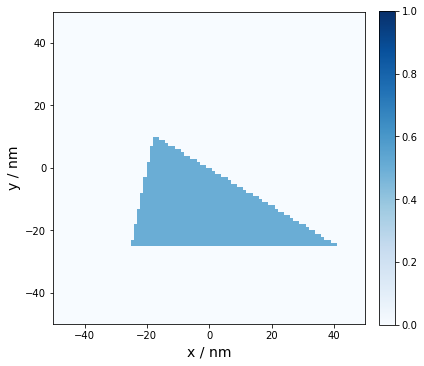

In [6]:
plot_2d(X,Y,Z,P)

In [7]:
Prot = rotate_bulk(P,20,30,0)

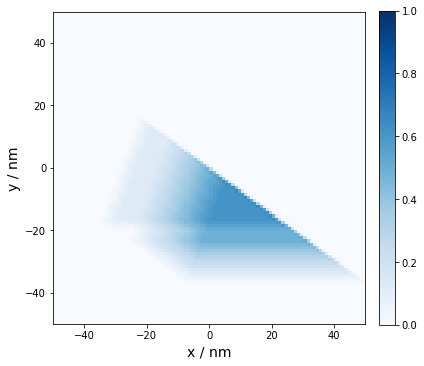

In [8]:
plot_2d(X,Y,Z,Prot)

- projection direction is normal to the plane of the image
- [0,0,0] angles corresponds to a vector pointing in positive z [0,0,1]
https://math.stackexchange.com/questions/1637464/find-unit-vector-given-roll-pitch-and-yaw

In [7]:
def angle_to_vector(ax,ay,az):
    θ = az * np.pi/180 # yaw
    ϕ = ax * np.pi/180 # pitch
    ψ = ay * np.pi/180 # roll
    
    x = -np.sin(ψ)*np.cos(θ)-np.cos(ψ)*np.sin(ϕ)*np.sin(θ)
    y = np.sin(ψ)*np.sin(θ)-np.cos(ψ)*np.sin(ϕ)*np.cos(θ)
    z = np.cos(ψ)*np.cos(ϕ)
    
    return x,y,z

In [10]:
x,y,z = angle_to_vector(80,0,20)

In [11]:
x,y,z

(-0.33682408883346515, -0.9254165783983234, 0.17364817766693041)

In [8]:
def plot_plane(ax,v=[0,0,1]):
    x,y,z = v
    y = -y
    s=5
    # create x,y
    xx, yy = np.meshgrid(np.linspace(15/s,85/s,5), np.linspace(15/s,85/s,5))

    normal = [x,y,z]
    d = -np.array([50/s,50/s,50/s]).dot(normal)

    # calculate corresponding z
    zz = (-normal[0] * xx - normal[1] * yy - d) * 1. /normal[2]

    ax.plot_surface(xx, yy, zz, alpha=0.2,color='salmon')


    ax.plot([50/s,(50+50*x)/s],[50/s,(50+50*y)/s],[50/s,(50+50*z)/s],color='k')
    ax.plot([(50+50*x)/s],[(50+50*y)/s],[(50+50*z)/s],'o',color='red')


    im = ax.voxels(P[::s,::s,::s], facecolors=[0,0,1,.1], edgecolor=[1,1,1,0.1])



    # Add axis labels
    plt.xlabel('x / nm', fontsize=15)
    plt.ylabel('y / nm', fontsize=15)
    ax.set_zlabel('z / nm', fontsize=15)

    ax.set_xlim([0,100/s])
    ax.set_ylim([0,100/s])
    ax.set_zlim([0,100/s])

    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_zticklabels([])

In [9]:
def plot_both(P,ax,ay,az,save_path=None):
    # plot in 3D for a single tilt
    fig= plt.figure(figsize=(12,6))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')

    vx,vy,vz = angle_to_vector(ax,ay,az)
    Prot=rotate_bulk(P,ax,ay,az)
    plot_2d(X,Y,Z,Prot,ax=ax1,fig=fig)
    plot_plane(ax2,v=[vx,vy,vz])

    title = 'Projected density $(%i^{\circ},%i^{\circ},%i^{\circ})$' % (ax,ay,az)
    ax1.set_title(title,size=14)
    ax2.set_title('Projection direction visualised',size=14)
    
    if save_path != None:
        plt.savefig(save_path,bbox_inches='tight')

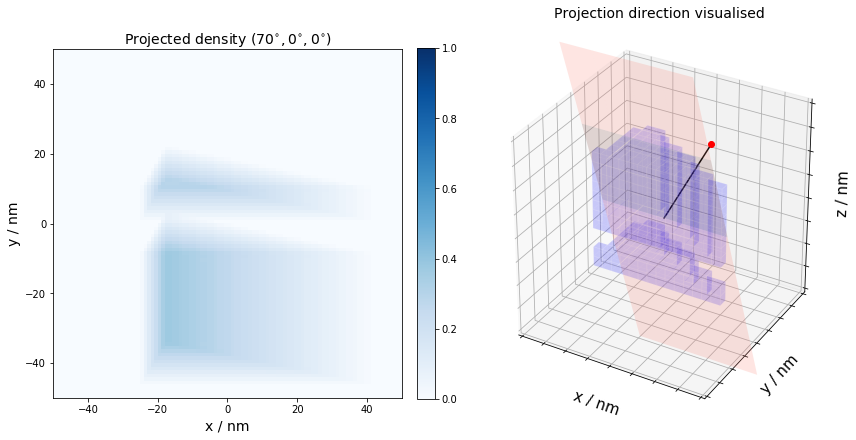

In [14]:
plot_both(P,70,0,0)

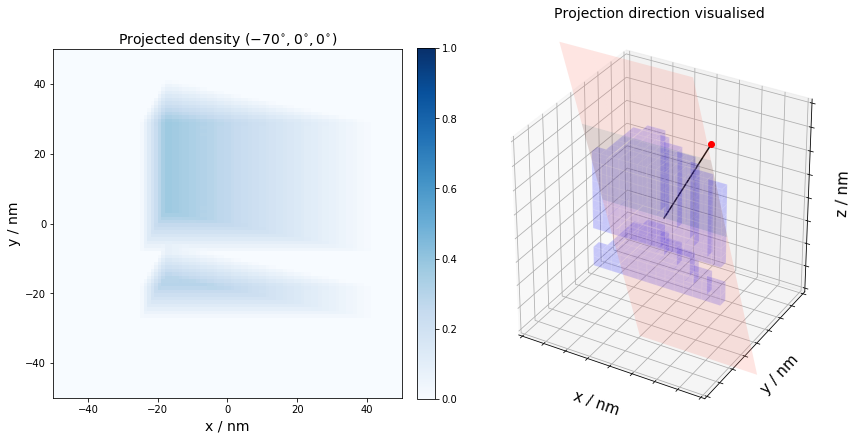

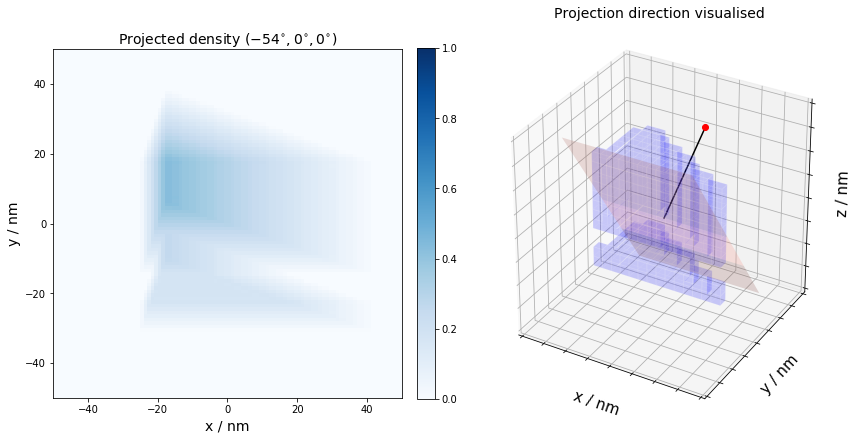

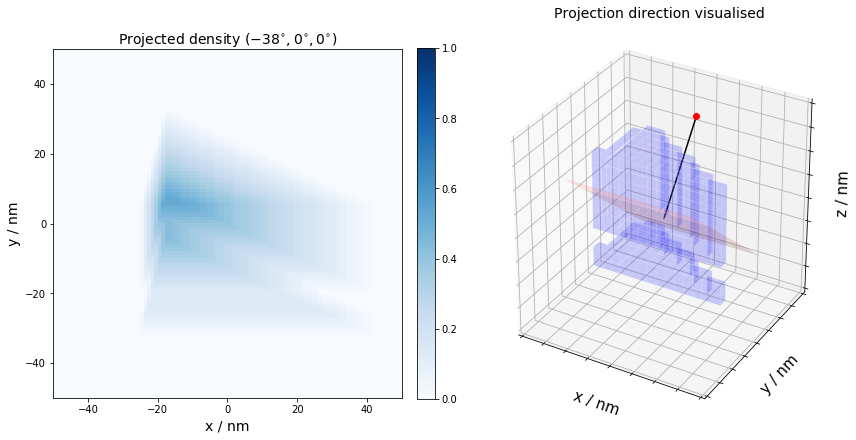

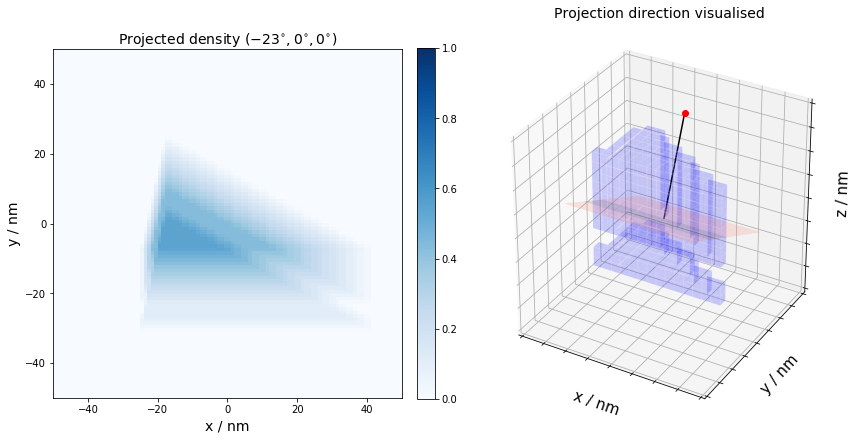

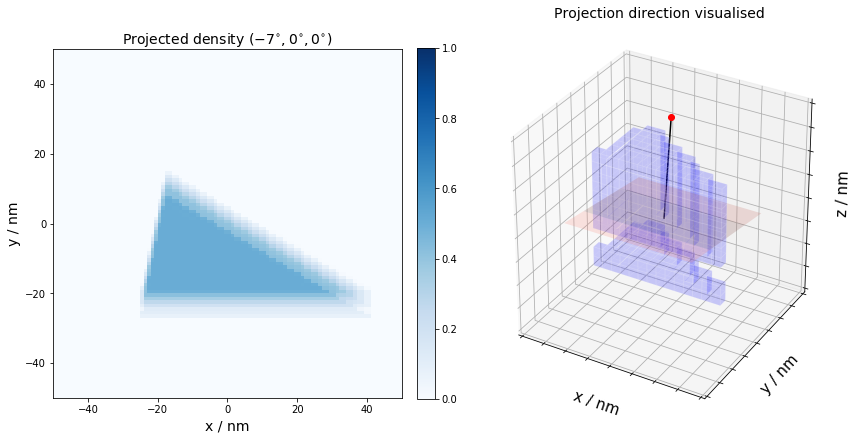

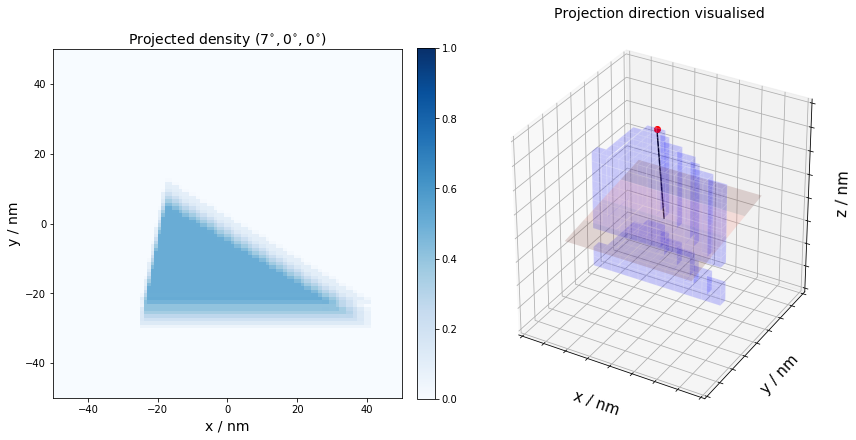

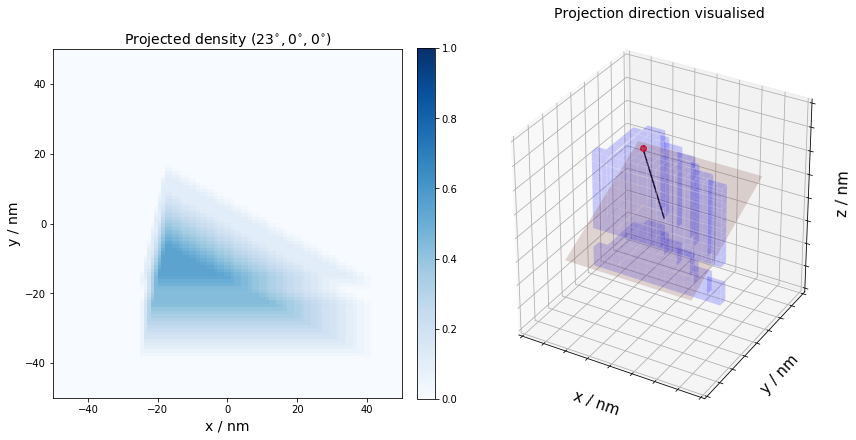

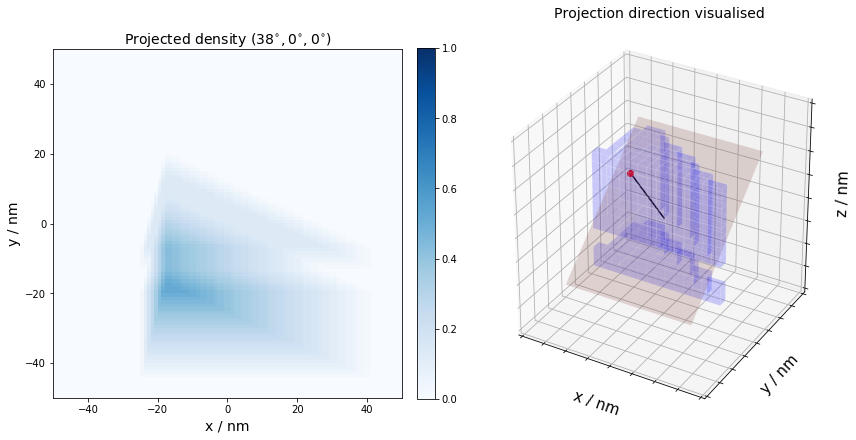

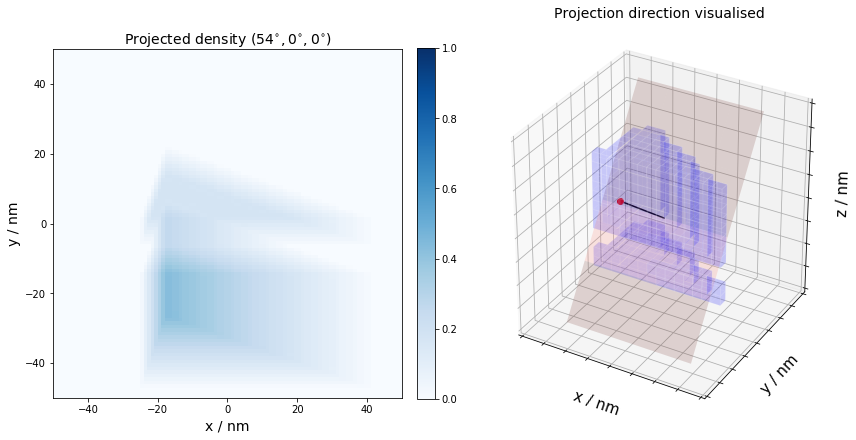

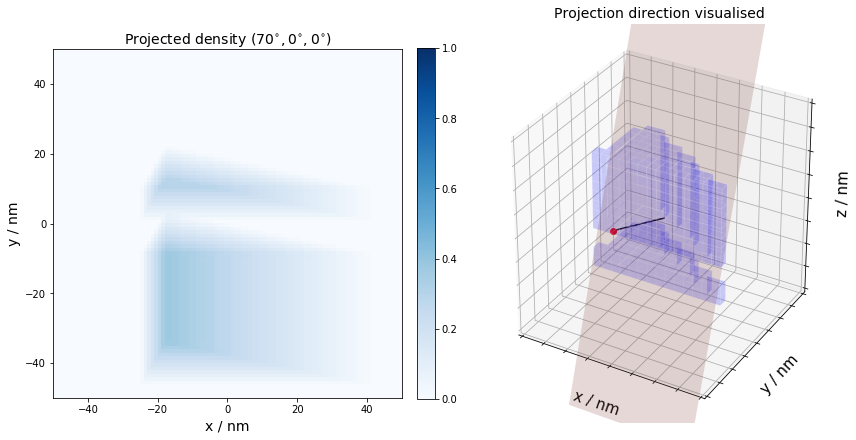

In [267]:
# make a gif
ax,ay,az = 0,0,0
for ax in np.linspace(-70,70,10):
    plot_both(P,ax,ay,az,save_path = r'C:\Users\grl31\Desktop\gif\%i %i %i.tiff' % (ax, ay, az))

In [269]:
fnames,images  = [], []
ax,ay,az = 0,0,0
for ax in np.linspace(-70,70,10):
    fnames.append(r'C:\Users\grl31\Desktop\gif\%i %i %i.tiff' % (ax, ay, az))

for filename in fnames:
    images.append(imageio.imread(filename))
for filename in fnames[::-1]:
    images.append(imageio.imread(filename))
    
imageio.mimsave(r'C:\Users\grl31\Desktop\gif\complete.gif', images)

(-1, 1)

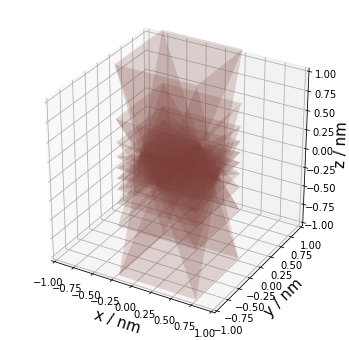

In [88]:
# plot in 3D for a tilt series
fig = plt.figure(figsize=(6,6))
ax1 = fig.gca(projection='3d')

ax,ay,az=0,0,0

for ax in np.linspace(-70,70,10):
    x,y,z = angle_to_vector(ax,ay,az)
    # create x,y
    xx, yy = np.meshgrid(np.linspace(-0.5,0.5,5), np.linspace(-0.5,0.5,5))

    normal = [x,y,z]
    d = 0#-np.array([0,0,0]).dot(normal)

    # calculate corresponding z
    zz = (-normal[0] * xx - normal[1] * yy - d) * 1. /normal[2]

    ax1.plot_surface(xx, yy, zz, alpha=0.2,color='salmon')

ax = 0
for ay in np.linspace(-70,70,10):
    x,y,z = angle_to_vector(ax,ay,az)
    # create x,y
    xx, yy = np.meshgrid(np.linspace(-0.5,0.5,5), np.linspace(-0.5,0.5,5))

    normal = [x,y,z]
    d = 0#-np.array([0,0,0]).dot(normal)

    # calculate corresponding z
    zz = (-normal[0] * xx - normal[1] * yy - d) * 1. /normal[2]

    ax1.plot_surface(xx, yy, zz, alpha=0.2,color='salmon')

# Add axis labels
plt.xlabel('x / nm', fontsize=15)
plt.ylabel('y / nm', fontsize=15)
ax1.set_zlabel('z / nm', fontsize=15)

ax1.set_xlim([-1,1])
ax1.set_ylim([-1,1])
ax1.set_zlim([-1,1])

## Generate tilt series

In [10]:
ax,ay,az = 0,0,0

P_projs = []
for ax in np.linspace(-70,70,10):
    P_rot = rotate_bulk(P,ax,ay,az)
    P_rot_proj =np.flipud(np.mean(P_rot,axis=2).T)
    P_projs.append(P_rot_proj)

In [11]:
raw_data = P_projs

## Save as Tiff stack

In [16]:
def imlist_to_tiffstack(ims, save_path=False):
    """ Converts list of images [im1,im2,im3...] into stack compatible with tomography,
        and converts as a tiff stack if a filepath is provided """
    # Get dimensions
    dims = np.shape(ims)
    
    # Convert to stack of images
    imstack = np.concatenate(ims).reshape(dims[0],dims[1],dims[2])
    
    # Rescale and convert to uint8
    imstack = np.array(imstack/np.max(imstack)*255, dtype=np.uint8)
    
    # Save if desired
    if save_path != False:
        with tifffile.TiffWriter(save_path, imagej=True) as tif:
            tif.save(imstack)
    
    return imstack
    
    

In [17]:
stack = imlist_to_tiffstack(P_projs,save_path=r'C:\Users\grl31\Desktop\xonly.tiff')

# Reconstruct

In [74]:
def single_ax_sirt(fpath,theta,niter):
    im = hs.load(fpath)
    im = hs.signals.Signal2D(np.transpose(im,axes=[2,1,0]))
    
    recon = tomopy.recon(im.data, theta, algorithm='sirt',num_iter = niter)

    # Recover orientation of im
    recon = np.transpose(recon,axes=(0,2,1))
    recon = recon[:,::-1,::-1];
    
    return recon

In [76]:
fpath = r'C:\Users\grl31\Desktop\xonly.tiff'
theta = np.linspace(-70,70,10) * np.pi/180

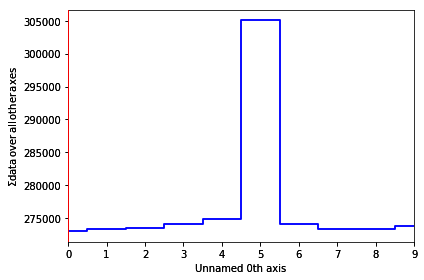

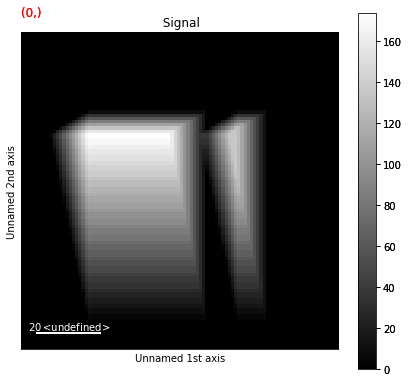

In [18]:
%matplotlib qt
im = hs.load(r'C:\Users\grl31\Desktop\xonly.tiff')
im = hs.signals.Signal2D(np.transpose(im,axes=[2,1,0]))
im.plot()

In [20]:
theta = np.linspace(-70,70,10) * np.pi/180
theta

array([-1.22173048, -0.95023481, -0.67873915, -0.40724349, -0.13574783,
        0.13574783,  0.40724349,  0.67873915,  0.95023481,  1.22173048])

In [21]:
recon = tomopy.recon(im.data, theta, algorithm='sirt',num_iter = 10)

# Recover orientation of im
recon = np.transpose(recon,axes=(0,2,1))
recon = recon[:,::-1,::-1];

Reconstructing 4 slice groups with 4 master threads...


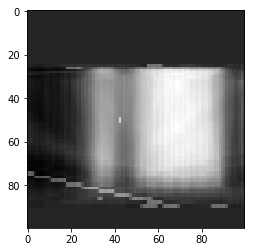

In [33]:
plt.imshow(recon[:,31,:])

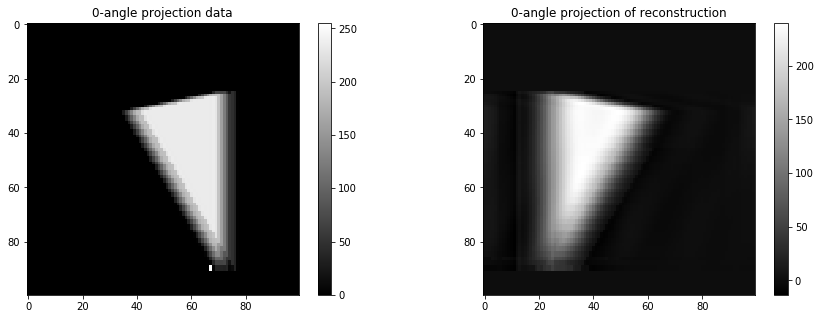

In [34]:
plt.figure(figsize=(15,5))
plt.subplot(121)
#plt.imshow(raw_data[abs(angles).argmin()], vmin=raw_data.min(), vmax=1) # plots the data collected at ~0 degree tilt
plt.imshow(im.data[4], vmin=im.data.min(), vmax=255)
plt.title('0-angle projection data')
plt.colorbar()
plt.subplot(122)
plt.imshow(recon.sum(2), vmin=im.data.min(), vmax=255)
plt.title('0-angle projection of reconstruction')
plt.colorbar()
plt.show()

In [27]:
def plot_all3(P,recon,ax,ay,az,save_path=None):
    # Note there is something funny with the +ve/-ve angles of projection direction vs rotation of object
    # plot in 3D for a single tilt
    fig= plt.figure(figsize=(12,6))
    ax1 = fig.add_subplot(1, 3, 1)
    ax2 = fig.add_subplot(1, 3, 2)
    ax3 = fig.add_subplot(1, 3, 3, projection='3d',aspect='equal')

    vx,vy,vz = angle_to_vector(ax,ay,az)
    Prot_dat=rotate_bulk(P,ax,ay,az)
    Prot_rec=rotate_bulk(recon,ax,ay,az)
    plot_2d(X,Y,Z,Prot_dat,ax=ax1,fig=fig)
    plot_2d(X,Y,Z,Prot_rec,ax=ax2,fig=fig)
    plot_plane(ax3,v=[vx,vy,vz])

    ax1.set_title('Projected data',size=14)
    ax2.set_title('Reconstructed data',size=14)
    ax3.set_title('$(%i^{\circ},%i^{\circ},%i^{\circ})$' % (ax,ay,az),size=14)
    
    plt.tight_layout()
    if save_path != None:
        plt.savefig(save_path,bbox_inches='tight')
        
    

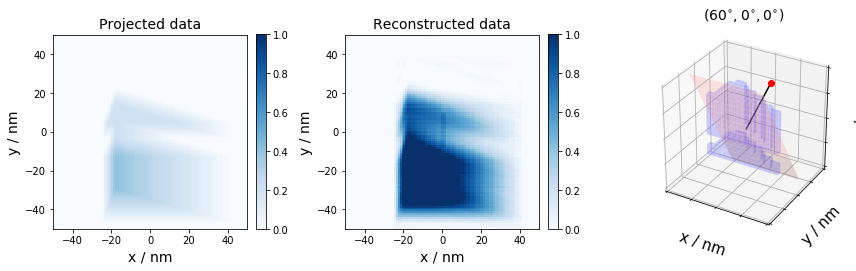

In [28]:
plot_all3(P,recon,60,0,0)

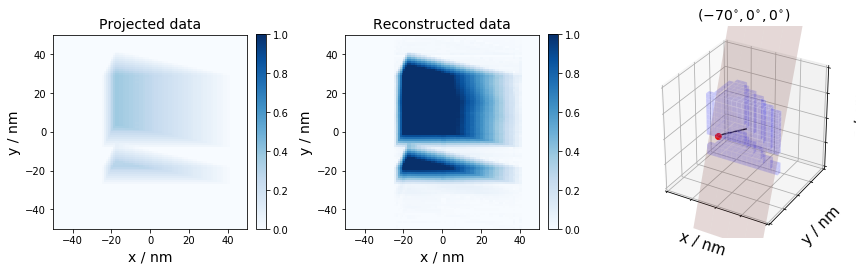

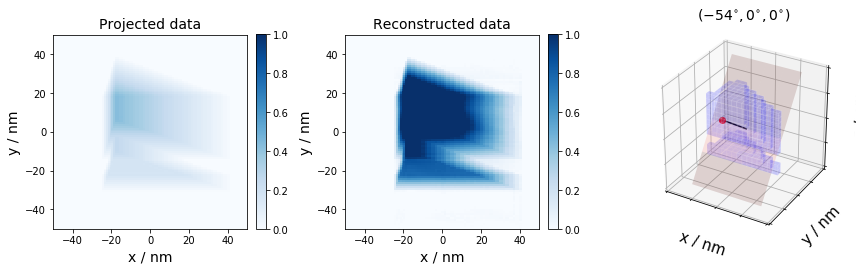

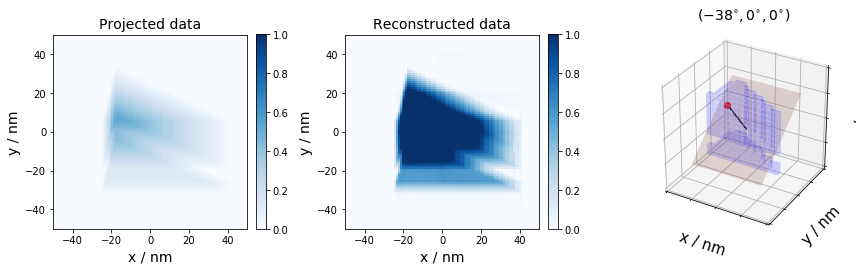

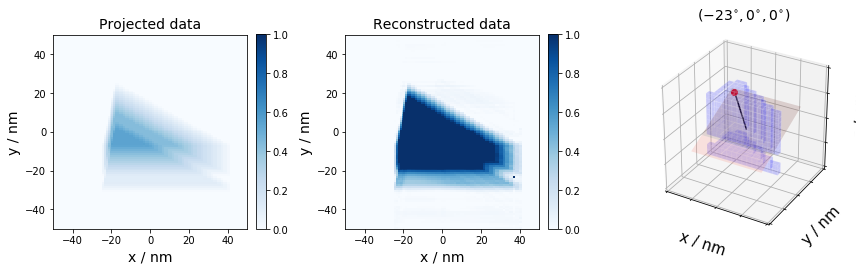

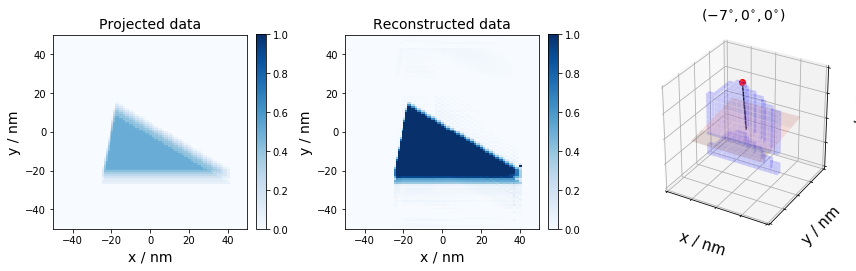

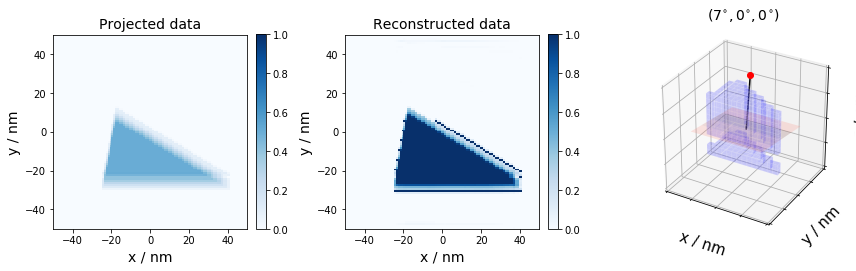

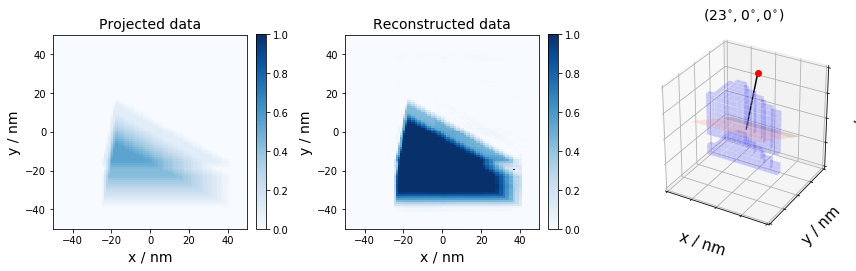

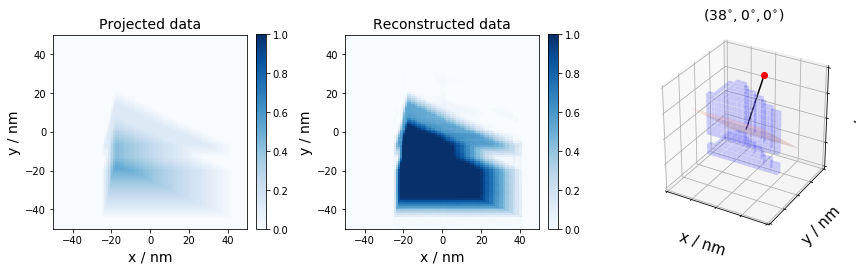

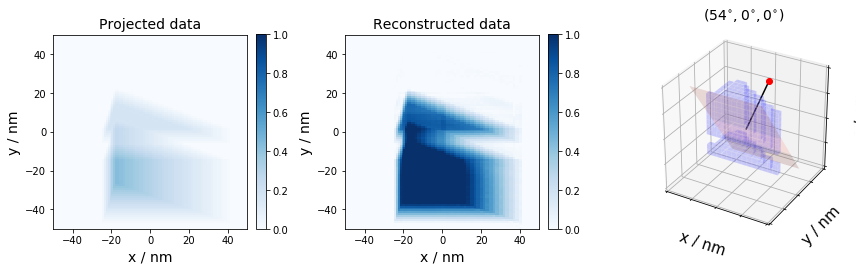

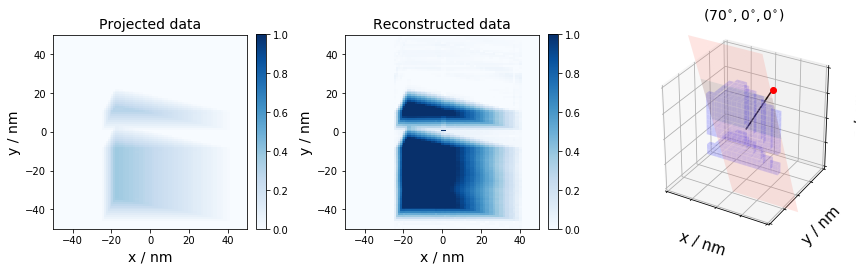

In [389]:
# gif again
ax,ay,az = 0,0,0
for ax in np.linspace(-70,70,10):
    plot_all3(P,recon,ax,ay,az,save_path = r'C:\Users\grl31\Desktop\gif\recon\%i %i %i.tiff' % (ax, ay, az))

In [391]:
fnames,images  = [], []
ax,ay,az = 0,0,0
for ax in np.linspace(-70,70,10):
    fnames.append(r'C:\Users\grl31\Desktop\gif\recon\%i %i %i.tiff' % (ax, ay, az))

for filename in fnames:
    images.append(imageio.imread(filename))
for filename in fnames[::-1]:
    images.append(imageio.imread(filename))
    
imageio.mimsave(r'C:\Users\grl31\Desktop\gif\recon\complete.gif', images, duration=.5)

New shape

## Evaluate performance

In [12]:
def phantom_error(beta,recon,P):
    a = np.linalg.norm(recon*beta-P)
    b = np.linalg.norm(P)
    return a/b

In [70]:
opt = scipy.optimize.minimize(phantom_error,1,args=(recon,P))
beta = opt.x[0]

In [78]:
opt.fun

0.5326812218616555

In [72]:
phantom_error(beta,recon,P)

0.5326812218069185

In [85]:
errs = []
for niter in [2,5,10,15,20,30]:
    recon = single_ax_sirt(fpath,theta,niter)
    opt = scipy.optimize.minimize(phantom_error,1,args=(recon,P))
    err = opt.fun
    errs.append(err)

Reconstructing 4 slice groups with 4 master threads...
Reconstructing 4 slice groups with 4 master threads...
Reconstructing 4 slice groups with 4 master threads...
Reconstructing 4 slice groups with 4 master threads...
Reconstructing 4 slice groups with 4 master threads...
Reconstructing 4 slice groups with 4 master threads...


Text(0, 0.5, 'Phantom error')

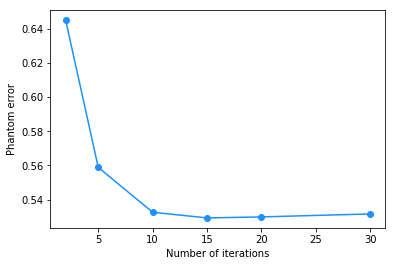

In [86]:
plt.plot([2,5,10,15,20,30],errs,'-o',color='dodgerblue')
plt.xlabel('Number of iterations')
plt.ylabel('Phantom error')

## Multi axis


In [ ]:
fpath = r'Dropbox (Cambridge University)/Linux-Surface share/RegTomoRecon/RegTomoReconMulti.py'

In [55]:
import importlib.util
spec = importlib.util.spec_from_file_location(r'RegTomoReconMulti.py', r'C:/Users/grl31/Dropbox (Cambridge University)/Linux-Surface share/RegTomoRecon/RegTomoReconMulti.py')
rtr = importlib.util.module_from_spec(spec)
spec.loader.exec_module(rtr)

In [16]:
from PIL import Image

In [37]:
import skimage

ModuleNotFoundError: No module named 'skimage'

In [16]:
# fpath = r'C:\Users\grl31\Desktop\xonly.tiff'
# raw_data = plt.imread(fpath)
np.shape(raw_data)
raw_data = np.array(raw_data)

In [4]:
im = hs.load(r'C:\Users\grl31\Desktop\xonly.tiff')
raw_data = im.data

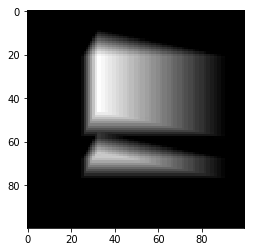

In [16]:
plt.imshow(raw_data[0,:,:])

In [12]:
raw_data = raw_data -  raw_data.min()
raw_data = raw_data/raw_data.max()

In [56]:
# reshape so z is middle column
raw_data = np.transpose(raw_data,axes=[1,0,2])

In [57]:
np.shape(raw_data)

(100, 10, 100)

In [13]:
angles = np.linspace(-70,70,10)
theta = angles * np.pi/180

In [58]:
vectors = np.zeros((10,12))

for i in range(10):
    a = theta[i]
    vectors[i,0:3] = [np.sin(a),0,-np.cos(a)] # ray direction r
    vectors[i,3:6] = [0,0,0] # centre of detector
    vectors[i,6:9] = [np.cos(a),0,np.sin(a)] # u (det +y)
    vectors[i,9:12] = [0,1,0] # v (det +x)
    
proj_geom = astra.create_proj_geom('parallel3d_vec',100,100,vectors)

In [59]:
vol_geom = astra.create_vol_geom(raw_data.shape[0],raw_data.shape[1],raw_data.shape[2])

In [61]:
proj_id = astra.data3d.create('-proj3d',proj_geom,raw_data)

In [62]:
vol_id = astra.data3d.create('-vol',vol_geom,0)

In [63]:
alg_id = astra.algorithm.create('SIRT3D')

IndexError: index out of range

Exception ignored in: 'astra.utils.readDict'
IndexError: index out of range


Exception: Unknown Algorithm.

In [54]:
raw_data.shape[0],raw_data.shape[1],raw_data.shape[2]

(10, 100, 100)

In [36]:
np.shape(raw_data)

(10, 100, 100)

In [14]:
data = rtr.tomo_data(np.array(raw_data), angles,degrees=True,
                    tilt_axis=0, stack_dim=1)

NameError: name 'rtr' is not defined

In [62]:
vol_shape = (data.shape[0],data.shape[2],data.shape[2])

projector = data.getOperator(vol_shape=vol_shape,
                           backend='astra', GPU=False)

Exception: Unknown Projector3D type.

In [51]:
np.shape(raw_data)

(10, 100, 100)